<a href="https://colab.research.google.com/github/jsstar522/hunkim_ML/blob/master/GAN/02_MNIST_GAN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 데이터를 GAN으로 생성하기

## 데이터
MNIST에 있는 데이터를 활용해 새로운 데이터를 GAN 모델을 통해 생성해보겠습니다. 먼저 `X input`은 이미지 셀 데이터(28 x 28)이고 Z 값은 `Noise Z`로 128 dimension을 임의로 설정합니다.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)
## MNIST 28 x 28
X = tf.placeholder(tf.float32, [None, 28*28])
## Noise Dimension 128
Z = tf.placeholder(tf.float32, [None, 128])

W0826 09:12:48.511830 140695048845184 deprecation.py:323] From <ipython-input-2-0f266e1a071b>:6: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0826 09:12:48.513386 140695048845184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0826 09:12:48.514466 140695048845184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./mnist/data/train-images-idx3-ubyte.gz


W0826 09:12:49.155801 140695048845184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0826 09:12:49.160726 140695048845184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz


W0826 09:12:49.457816 140695048845184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


## Generative Network

이제 Generative Network를 만들겠습니다. Generative Network에서 input은 `Noise Z`입니다. Noise Z가 들어가면 hidden layer 두개를 지나 28x28 dimension의 출력을 만드는 network를 구성하겠습니다. MNIST는 흑백의 28x28 이미지 이므로 출력시 sigmoid를 적용합니다. (명암도 0~1)

In [0]:
G_W1 = tf.Variable(tf.random_normal([128, 256], stddev=0.01))
G_W2 = tf.Variable(tf.random_normal([256, 28*28], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([256]))
G_b2 = tf.Variable(tf.zeros([28*28]))

def generator(noise_z):
    hidden = tf.nn.relu(tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, G_W2) + G_b2)
    return output

## Discriminator Network

Discriminator Network는 Generative Network와 반대의 개념으로 생각하면 됩니다. input값으로 28x28 image 데이터가 들어가고 ouput은 0~1(True or Fasle)의 값이 나옵니다.

In [0]:
D_W1 = tf.Variable(tf.random_normal([28*28, 256], stddev=0.01))
D_W2 = tf.Variable(tf.random_normal([256, 1], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([256]))
D_b2 = tf.Variable(tf.zeros([1]))

def discriminator(inputs):
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, D_W2) + D_b2)
    return output

## Fake Image, Loss and Opt

Fake image가 움직이는 과정은 다음과 같습니다. Noise를 Generator에 넣어 Fake image를 생성하고 Loss를 구한 뒤 Optimizer를 사용합니다. Loss 값은 다음과 같이 정의합니다.

GAN에서 학습이 되는 과정은 Noise가 Generator를 통과한 값 (Fake image)이 Discriminator에서 진짜인지(True) 가짜인지(False) 판별합니다. 0~1의 값을 판별하는 과정이므로 `Cross Entropy로 Loss`를 정의하면 됩니다. 3가지로 ouput의 Loss를 정의합니다.

* (Discriminator) Real Data와 1 사이의 Loss
* (Discriminator) Fake Data와 0 사이의 Loss
* (Generator) Fake Data와 1 사이의 Loss

**첫번째와 두번째는 Discriminator가 Real Data와 Fake Data가 각각 1과 0으로 잘 구별할 수 있도록 학습됩니다. 세번째는 Generator가 Fake Data를 1이 되게끔 만들 수 있도록 학습합니다.**

Cross Entropy로 정의하는 Cost Function (Loss)는 다음과 같습니다.

$$Cost(H(x), y) = -ylog(H(x)) - (1-y)log(1-H(x))$$

먼저 Discriminator Cost Function을 구해보면,

* Discriminator에 real image input data (x)가 들어갔을 때, 예측값 $D(x)$과 $y=1$
$$D_{realLoss} = Cost(D(x), 1)$$
$$= -log(D(x))$$

* Generator에 fake image input data (G(noise z))가 들어갔을 때, 예측값 $D(G(z))$과 $y=0$
$$D_{fakeLoss} = Cost(D(G(z)), 0)$$
$$= -log(1-D(G(z)))$$

이 두개의 식이 선형결합으로 이어지면 최종적으로,

$$D_{loss} = -log(D(x)) - log(1-D(G(z)))$$

가 됩니다.

이어서 Generator는 다음과 같습니다. fake image input data (G(noise z))가 들어갔을 때, 예측값 $D(G(z))$과 $y=1$ 이므로,

$$G_{loss} = -log(D(G(z)))$$


Generator와 Discriminator는 별개로 학습됩니다.


In [0]:
## fake image
G = generator(Z)

loss_D = -tf.reduce_mean(tf.log(discriminator(X)) + tf.log(1-discriminator(G)))
loss_G = -tf.reduce_mean(tf.log(discriminator(G)))

train_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=[D_W1, D_b1, D_W2, D_b2])
train_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=[G_W1, G_b1, G_W2, G_b2])

## Training Start

이제 변수부터 Optimizer까지 모두 정의해줬으므로 Session을 열고 초기화한 뒤, 학습을 시작합니다.

KeyboardInterrupt: ignored

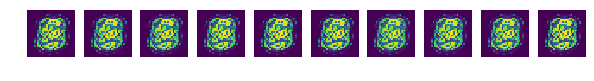

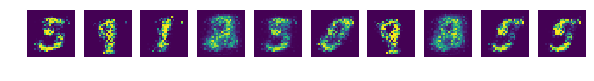

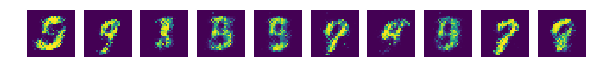

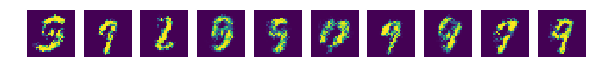

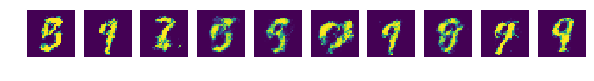

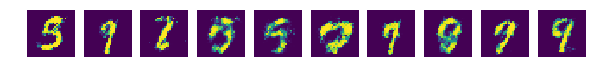

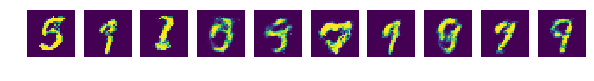

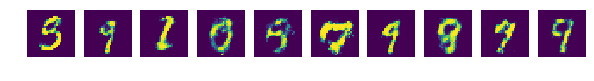

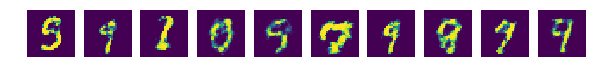

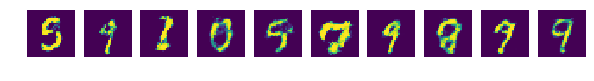

In [24]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## test size (num_sample = 10, Dimension = 128)
noise_test = np.random.normal(size=(10, 128))

for epoch in range(200):
    for i in range(int(mnist.train.num_examples / 100)):
        batch_xs, _ = mnist.train.next_batch(100)
        noise = np.random.normal(size=(100, 128))
        
        sess.run(train_D, feed_dict={X: batch_xs, Z: noise})
        sess.run(train_G, feed_dict={Z: noise})
        
    if epoch == 0 or (epoch + 1) % 10 == 0:
        samples = sess.run(G, feed_dict={Z: noise_test})
        
        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))